### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [32]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [33]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [34]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Sub_Category'])


In [35]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)


In [36]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [37]:
data = data.groupby('Sub_Category').filter(lambda x : len(x)>2000)

In [38]:
data.Sub_Category.value_counts()

Availability           11626
Enterprise software    11429
Job Failure             7399
Poor performance        4480
Data Issue              4105
Website                 3425
Desktop Software        2203
Name: Sub_Category, dtype: int64

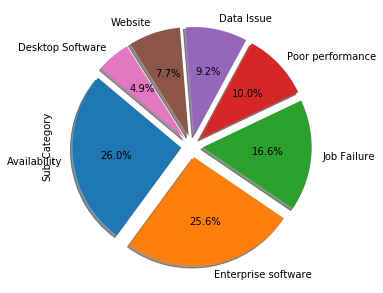

In [39]:
chart=data.Sub_Category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Sub_Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [40]:
from sklearn.utils import resample

df_1 = data[data.Sub_Category=='Availability']
df_2 = data[data.Sub_Category=='Enterprise software']
df_3 = data[data.Sub_Category=='Job Failure']
df_4 = data[data.Sub_Category=='Poor performance']
df_5 = data[data.Sub_Category=='Data Issue']
df_6 = data[data.Sub_Category=='Website']
df_7 = data[data.Sub_Category=='Desktop Software']
 
df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled])

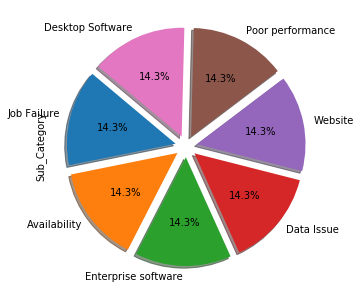

In [41]:
chart=data.Sub_Category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Sub_Category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [42]:
data['target_sub'] = data.Sub_Category.astype('category').cat.codes


In [43]:
labels_sub = data.Sub_Category.astype('category').cat.categories


In [44]:
df = pd.DataFrame(labels_sub)
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_sub.csv') 


In [45]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sub
9138,INC000020230801,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,Closed Complete,Data Issue,NaN,CBT RR COG,HASHIM BASHA MUBARAK (643026387),KB000010048673,GLOBAL,2019-05-21 18:42,2019-05-22 4:18,0
5829,INC000019711063,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Large,GFS - FP&A - FINANCIAL REPORTING,...,Closed Complete,Data Issue,NaN,CBT RR COG,SIVA KUMAR POLISETTY (643020471),KB000010055400,GLOBAL,2019-02-03 20:51,2019-02-04 19:32,0
11610,INC000020115943,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,Closed Complete,Data Issue,NaN,CBT RR COG,VIJAYASEKHAR REDDY (643025460),KB000010048673,GLOBAL,2019-04-29 4:17,2019-04-29 18:37,0
26501,INC000019926436,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,ASPAC DNA PLATFORM,...,Closed Complete,Job Failure,NaN,ASPAC CONSUMER DNA L2,AMIT KUMAR SINHA (643025955),NaN,ASPAC,2019-03-21 0:29,2019-03-27 9:14,0
44104,INC000020116812,Sales Recon didn't matched job name: Wrapper_C...,Sales Recon didn't matched job name: Wrapper_C...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Large,CANADA COMM OPS IMPACT - PROD,...,Closed Complete,Data Issue,NaN,DATA AND ANALYTICS RR LTI,KIRANBABU KARNI (643020263),KB000010067679,NaN,2019-04-29 6:47,2019-04-30 7:03,0


In [46]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [47]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,20,50,100, np.inf], labels=['0-10', '10-20', '20-50','50-100' ,'>100'])


In [48]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [49]:
word_distribution.head()

,bins,counts
0,0-10,3629
1,10-20,5171
2,20-50,3635
3,50-100,2263
4,>100,723


Text(0.5, 1.0, 'Word distribution per bin')

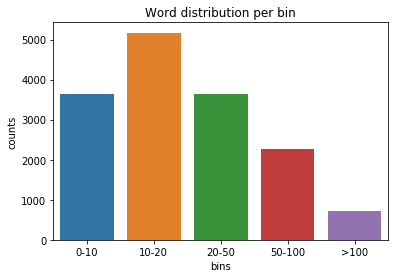

In [50]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [51]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sub,num_words,bins
9138,INC000020230801,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,NaN,CBT RR COG,HASHIM BASHA MUBARAK (643026387),KB000010048673,GLOBAL,2019-05-21 18:42,2019-05-22 4:18,0,18,10-20
5829,INC000019711063,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Large,GFS - FP&A - FINANCIAL REPORTING,...,NaN,CBT RR COG,SIVA KUMAR POLISETTY (643020471),KB000010055400,GLOBAL,2019-02-03 20:51,2019-02-04 19:32,0,18,10-20
11610,INC000020115943,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,NaN,CBT RR COG,VIJAYASEKHAR REDDY (643025460),KB000010048673,GLOBAL,2019-04-29 4:17,2019-04-29 18:37,0,18,10-20
26501,INC000019926436,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,ASPAC DNA PLATFORM,...,NaN,ASPAC CONSUMER DNA L2,AMIT KUMAR SINHA (643025955),NaN,ASPAC,2019-03-21 0:29,2019-03-27 9:14,0,15,10-20
44104,INC000020116812,Sales Recon didn't matched job name: Wrapper_C...,Sales Recon didn't matched job name: Wrapper_C...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Large,CANADA COMM OPS IMPACT - PROD,...,NaN,DATA AND ANALYTICS RR LTI,KIRANBABU KARNI (643020263),KB000010067679,NaN,2019-04-29 6:47,2019-04-30 7:03,0,13,10-20


In [52]:
num_class_sub = len(np.unique(data.Sub_Category.values))
y_sub = data['target_sub'].values


## Topic Modelling

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [54]:
data['Description'] = data['Description'].astype(str)

In [55]:
type(data['Description'])

pandas.core.series.Series

In [56]:
data_description = data.Description.values

In [57]:
type(data_description)

numpy.ndarray

In [58]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

000000 9.95040315983296
00000000 9.95040315983296
000000000015061379 9.95040315983296
000000000019804817 9.95040315983296
000000000043309730 9.95040315983296
000000000111809503 9.95040315983296
000000000520001500 9.95040315983296
000000000520016500 9.95040315983296
000000000520016600 9.95040315983296
000000000520016700 9.95040315983296
000000010000000d0000000d 9.95040315983296
0000023001 9.95040315983296
000004026995 9.95040315983296
000004026996 9.95040315983296
000004026997 9.95040315983296
000004026998 9.95040315983296
000004026999 9.95040315983296
000004027000 9.95040315983296
000004027001 9.95040315983296
000004027002 9.95040315983296
000004027003 9.95040315983296
000004027101 9.95040315983296
000004027102 9.95040315983296
000004027103 9.95040315983296
000004027104 9.95040315983296
000005170 9.95040315983296
0000082549 9.95040315983296
000010 9.95040315983296
000011 9.95040315983296
0000153883 9.95040315983296
000020 9.95040315983296
00002400 9.95040315983296
00002406 9.9504031598

31294 9.95040315983296
31295 9.95040315983296
31298 9.95040315983296
3132421 9.95040315983296
31328 9.95040315983296
313280 9.95040315983296
31473 9.95040315983296
31474 9.95040315983296
31514 9.95040315983296
31673 9.95040315983296
31674 9.95040315983296
31675 9.95040315983296
31676 9.95040315983296
31682 9.95040315983296
31684 9.95040315983296
31685 9.95040315983296
31778 9.95040315983296
3182 9.95040315983296
31th 9.95040315983296
3200 9.95040315983296
32000 9.95040315983296
320000 9.95040315983296
3210176078 9.95040315983296
3210176652 9.95040315983296
3210183243 9.95040315983296
323 9.95040315983296
324 9.95040315983296
3251484 9.95040315983296
3255 9.95040315983296
3269 9.95040315983296
326k 9.95040315983296
32767 9.95040315983296
3289 9.95040315983296
32_363_8357708556407862244 9.95040315983296
32en000 9.95040315983296
32es100 9.95040315983296
32k 9.95040315983296
32s 9.95040315983296
3300 9.95040315983296
330000 9.95040315983296
3307 9.95040315983296
330k 9.95040315983296
331 9

56007 9.95040315983296
5628 9.95040315983296
5644 9.95040315983296
5647 9.95040315983296
564885 9.95040315983296
5652 9.95040315983296
56800 9.95040315983296
5710 9.95040315983296
573 9.95040315983296
573260 9.95040315983296
5748 9.95040315983296
5797 9.95040315983296
57k 9.95040315983296
58375 9.95040315983296
58407054f745 9.95040315983296
58653 9.95040315983296
587 9.95040315983296
5874 9.95040315983296
589 9.95040315983296
58998 9.95040315983296
59045 9.95040315983296
593 9.95040315983296
594 9.95040315983296
5940 9.95040315983296
59576 9.95040315983296
596 9.95040315983296
597 9.95040315983296
5976 9.95040315983296
5977 9.95040315983296
5982 9.95040315983296
598549962 9.95040315983296
5988 9.95040315983296
5989 9.95040315983296
5991 9.95040315983296
5992 9.95040315983296
5b3d670c 9.95040315983296
5c9b 9.95040315983296
5cbkouki 9.95040315983296
5ccriarce0 9.95040315983296
5cemea 9.95040315983296
5cghs 9.95040315983296
5d3f 9.95040315983296
5dac56573895 9.95040315983296
5db26787c5f5 

calulated 9.95040315983296
calweek 9.95040315983296
cambiarían 9.95040315983296
cambiato 9.95040315983296
cambios 9.95040315983296
cambodia 9.95040315983296
camila 9.95040315983296
camstar 9.95040315983296
camstarportal 9.95040315983296
canada_onemd_integration 9.95040315983296
canadabi_sales_analytics_tab_extract_refresh 9.95040315983296
cancellation 9.95040315983296
canda 9.95040315983296
candidate 9.95040315983296
canfield 9.95040315983296
cannnot 9.95040315983296
cannot_insert_update_activity_entity 9.95040315983296
canopy 9.95040315983296
capai22_customer 9.95040315983296
capai24_customer 9.95040315983296
capai32_sg_post_impala 9.95040315983296
capai32_thailand 9.95040315983296
capai34_anz_perenso 9.95040315983296
capgemini 9.95040315983296
capitalplasticsurgery 9.95040315983296
caps 9.95040315983296
capsules 9.95040315983296
capta 9.95040315983296
car 9.95040315983296
caran 9.95040315983296
cardinale 9.95040315983296
cardinalityestimate 9.95040315983296
cardio 9.95040315983296
ca

finds 9.95040315983296
finkal 9.95040315983296
fiorini 9.95040315983296
firing 9.95040315983296
fisc_mo_id 9.95040315983296
fisc_yr_per 9.95040315983296
fiscais 9.95040315983296
fiscal_end_date 9.95040315983296
fiscal_month 9.95040315983296
fiscal_start_date 9.95040315983296
fiscal_year_period_nbr 9.95040315983296
fiscper3 9.95040315983296
fiscvarnt 9.95040315983296
fiscyear 9.95040315983296
fishflow 9.95040315983296
fishman 9.95040315983296
fitness 9.95040315983296
fixed_yn 9.95040315983296
fixes 9.95040315983296
fl 9.95040315983296
flatfiletrend_ethiconcustom_total 9.95040315983296
flexibility 9.95040315983296
flexible 9.95040315983296
flight 9.95040315983296
flor 9.95040315983296
flowed 9.95040315983296
flows 9.95040315983296
fls 9.95040315983296
flush 9.95040315983296
flushed 9.95040315983296
flying 9.95040315983296
fmontiel 9.95040315983296
foc 9.95040315983296
foc_indicator 9.95040315983296
foc_reason 9.95040315983296
focused 9.95040315983296
folgende 9.95040315983296
folks 9.950

lfshelpdesk 9.95040315983296
lg 9.95040315983296
lg_login 9.95040315983296
lhr 9.95040315983296
li1t6pd1dqqodcu6dzsf0 9.95040315983296
liabilites 9.95040315983296
lianxin 9.95040315983296
liao 9.95040315983296
libname 9.95040315983296
libpath 9.95040315983296
libpmsaprdr 9.95040315983296
librarybrowser 9.95040315983296
libsapnwrfc 9.95040315983296
licenced 9.95040315983296
licensing 9.95040315983296
lifescan_emea_france_orders_and_sales_cube 9.95040315983296
lifescan_emea_france_orders_and_sales_cube_tr 9.95040315983296
lifescan_france_orders_and_sales_cube 9.95040315983296
lifescan_migration_dp_cube_eq_units_rer_121_prd 9.95040315983296
lifescan_migration_dp_cube_rer_119_prd 9.95040315983296
lifescan_migration_lifescan_emea_sales_italy_prd 9.95040315983296
lifescan_migration_lifescan_emea_sales_prd 9.95040315983296
light 9.95040315983296
lign 9.95040315983296
ligou 9.95040315983296
lijst 9.95040315983296
likon 9.95040315983296
limitada 9.95040315983296
linear 9.95040315983296
liner 9.

registsrations 9.95040315983296
regmedeame 9.95040315983296
regras 9.95040315983296
regulated 9.95040315983296
regulation_name 9.95040315983296
regulations 9.95040315983296
regulatorios 9.95040315983296
regulatorycompliance 9.95040315983296
regulatórios 9.95040315983296
rehire 9.95040315983296
reinaldo 9.95040315983296
reinstalling 9.95040315983296
reis 9.95040315983296
rejuvenation 9.95040315983296
rekib 9.95040315983296
rekordbeteiligung 9.95040315983296
relacionadas 9.95040315983296
relate 9.95040315983296
relates 9.95040315983296
relative 9.95040315983296
relatórios 9.95040315983296
relay 9.95040315983296
relevance 9.95040315983296
reliability 9.95040315983296
reltio_out 9.95040315983296
remanda 9.95040315983296
remap 9.95040315983296
remapping 9.95040315983296
remark 9.95040315983296
remediate 9.95040315983296
remind 9.95040315983296
remoting 9.95040315983296
remya 9.95040315983296
renata 9.95040315983296
renato 9.95040315983296
rendered 9.95040315983296
rendering 9.95040315983296

tx 9.95040315983296
txt201709140407591910 9.95040315983296
type2 9.95040315983296
type_contact 9.95040315983296
type_name 9.95040315983296
type_template1 9.95040315983296
type_template2 9.95040315983296
typo 9.95040315983296
typography 9.95040315983296
typos 9.95040315983296
tzioumis 9.95040315983296
técnicas 9.95040315983296
u_call_log 9.95040315983296
u_country_codes 9.95040315983296
u_jnj_load_batch_job 9.95040315983296
u_jnj_load_printers 9.95040315983296
u_jnj_load_special_projects 9.95040315983296
u_nonconformance 9.95040315983296
u_res_cat_choices 9.95040315983296
u_service_level_ci_mapping 9.95040315983296
u_support_group2 9.95040315983296
uaf 9.95040315983296
uanble 9.95040315983296
uat2 9.95040315983296
uat_k6 9.95040315983296
uax 9.95040315983296
uax_outletscustoms 9.95040315983296
uax_tblroutes 9.95040315983296
uber 9.95040315983296
udc 9.95040315983296
uderstand 9.95040315983296
uf 9.95040315983296
ufr 9.95040315983296
ug 9.95040315983296
uide 9.95040315983296
uinable 9.95

In [59]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [60]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['000000' 'load_jtr_cust_sls_rep_algn' 'load_jtr_dwh_uhs_prod_catg_dim'
 'load_jtr_rpt_data_security' 'load_ymd' 'loader' 'loan'
 'loc_list_price_each' 'loc_list_price_each_uom' 'loc_prod']

Features with highest idf:
['ap_cognos_customer_mast' 'ap_etl_pos_yyyymm' 'ap_prod_prc_int1'
 'ap_sap_bw_copa10_trig' 'ap_services_check' 'ap_smallic8'
 'apachehttpprovider' 'apachesolr_site_hash' 'anyomre' 'última']


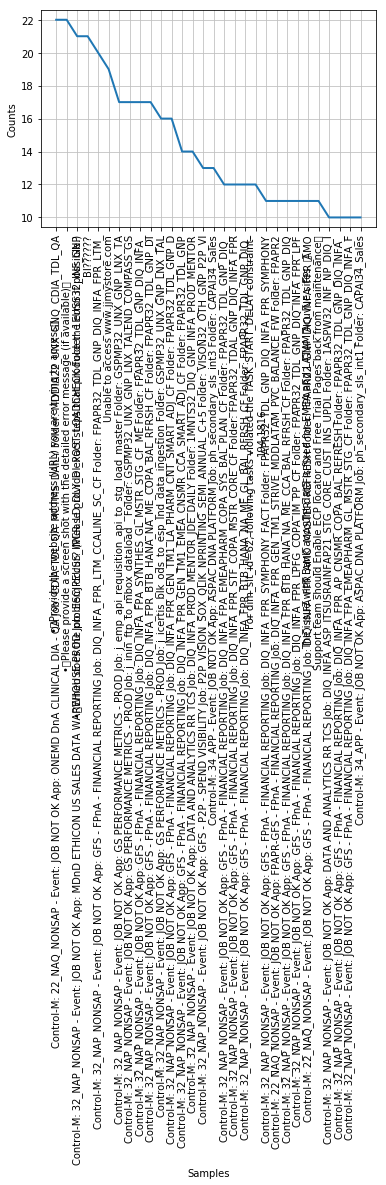

In [61]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [62]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(15421, 25067)
  (0, 9372)	0.1695409177549967
  (0, 3342)	0.18870900599855964
  (0, 11825)	0.1713004467949802
  (0, 15311)	0.28759606230149354
  (0, 17896)	0.12456534271533476
  (0, 18111)	0.1708106565026208
  (0, 7104)	0.16518453593438795
  (0, 12861)	0.20084866031810766
  (0, 12589)	0.21172895933696714
  (0, 12302)	0.20608401698614873
  (0, 20381)	0.19683627689103686
  (0, 10522)	0.5437325863489287
  (0, 12386)	0.16911538465135983
  (0, 12487)	0.5108630902026511
  (1, 9372)	0.1847859906634601
  (1, 3342)	0.20567766815414076
  (1, 11825)	0.18670373607300386
  (1, 15311)	0.31345662148702996
  (1, 17896)	0.13576622422942014
  (1, 18111)	0.18616990397164787
  (1, 7104)	0.1800378841822107
  (1, 12861)	0.2189089168665686
  (1, 12589)	0.23076756939445
  (1, 12302)	0.22461503537289013
  (1, 20381)	0.2145357410202259
  :	:
  (15419, 18315)	0.4202673432198634
  (15419, 22414)	0.23680200586314684
  (15419, 22464)	0.2462534632963552
  (15419, 24608)	0.22494590443664508
  (15419, 23112)	0.1970697

In [64]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


15421
                                             Description  index
9138   Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...   9138
5829   Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...   5829
11610  Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...  11610
26501  Control-M: 34_APP - Event: JOB NOT OK App: ASP...  26501
44104  Sales Recon didn't matched job name: Wrapper_C...  44104


In [65]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 7].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['When', 'did', 'this', 'issue', 'begin?:2018-02-06\n\nWho', 'is', 'this', 'affecting?:Self\n\nWhat', 'is', 'the', 'issue?:•', 'Jiff', '(mobile', 'app)', '\n•', 'Screenshot', 'not', 'available\n•', 'while', 'logging', 'in', 'I', 'receive', 'a', 'message', 'that', 'i', 'am', 'not', 'authorized', 'to', 'access', 'the', 'app\n\nWhat', 'is', 'the', 'business', 'impact?:None\n\nHave', 'you', 'attempted', 'any', 'troubleshooting?:No\n\nWhat', 'troubleshooting', 'steps', 'have', 'you', 'taken?:']


 tokenized and lemmatized document: 
['issu', 'begin', 'affect', 'self', 'issu', 'jiff', 'mobil', 'screenshot', 'avail', 'log', 'receiv', 'messag', 'author', 'access', 'busi', 'impact', 'attempt', 'troubleshoot', 'troubleshoot', 'step', 'take']


9138     [control, event, fpna, financi, report, folder...
5829     [control, event, fpna, financi, report, folder...
11610    [control, event, fpna, financi, report, folder...
26501     [control, event, aspac, platform, folder, capai]
44104             [sale, recon, match, miss, invoic, tabl]
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [66]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 control
1 event
2 financi
3 folder
4 fpapr
5 fpna
6 report
7 aspac
8 capai
9 platform
10 invoic


In [67]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(0, 1), (1, 1), (3, 1), (20, 1), (25, 1), (26, 1), (27, 1)]

In [68]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 0 ("control") appears 1 time.
Word 1 ("event") appears 1 time.
Word 3 ("folder") appears 1 time.
Word 20 ("prod") appears 1 time.
Word 25 ("gspmp") appears 1 time.
Word 26 ("metric") appears 1 time.
Word 27 ("perform") appears 1 time.


In [69]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.32455874462255613),
 (1, 0.3293320642510528),
 (2, 0.4317963895303202),
 (3, 0.3194851661242432),
 (4, 0.4501604987934149),
 (5, 0.4484900887790008),
 (6, 0.3064233753377564)]


### Finding out 5 topics using LDA

In [70]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [71]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.070*"start_tim" + 0.070*"end_tim" + 0.067*"dim_task_id" + 0.067*"task_nam" + 0.037*"error"'), (1, '0.071*"issu" + 0.058*"troubleshoot" + 0.033*"busi" + 0.031*"step" + 0.031*"impact"'), (2, '0.033*"data" + 0.023*"access" + 0.019*"report" + 0.018*"assign" + 0.017*"request"'), (3, '0.089*"folder" + 0.082*"control" + 0.080*"event" + 0.066*"report" + 0.044*"fpapr"'), (4, '0.077*"dim_task_id" + 0.071*"task_nam" + 0.065*"task" + 0.063*"dim_slt_id" + 0.061*"follow"')]
Topic: 0 
Words: 0.070*"start_tim" + 0.070*"end_tim" + 0.067*"dim_task_id" + 0.067*"task_nam" + 0.037*"error" + 0.017*"fail" + 0.014*"null" + 0.013*"file" + 0.012*"task" + 0.012*"tabl"
Topic: 1 
Words: 0.071*"issu" + 0.058*"troubleshoot" + 0.033*"busi" + 0.031*"step" + 0.031*"impact" + 0.030*"affect" + 0.030*"take" + 0.029*"attempt" + 0.029*"begin" + 0.020*"user"
Topic: 2 
Words: 0.033*"data" + 0.023*"access" + 0.019*"report" + 0.018*"assign" + 0.017*"request" + 0.014*"user" + 0.013*"sale" + 0.013*"group" + 0.012*"unabl" 

In [72]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [73]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [74]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [75]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(80, 5)
(5, 80)


In [76]:
df_lda

,access,account,affect,applic,assign,attach,attempt,begin,busi,check,...,task_nam,task_statu,team,tri,troubleshoot,type,unabl,user,violat,wwid
0,0.011707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066809,0.000000,0.000000,0.00000,0.000000,0.000000,0.008777,0.007610,0.008441,0.000000
1,0.007180,0.005215,0.029959,0.000000,0.000000,0.006721,0.029111,0.029019,0.033084,0.004306,...,0.000000,0.000000,0.007403,0.00444,0.057789,0.000000,0.000000,0.019872,0.000000,0.000000
2,0.022672,0.000000,0.000000,0.006069,0.018312,0.008509,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006904,0.00000,0.000000,0.005985,0.011508,0.013687,0.000000,0.008306
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008305,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.010443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.011198,0.000000,0.00000,0.000000,0.000000,0.000000,0.012520,0.058543,0.000000


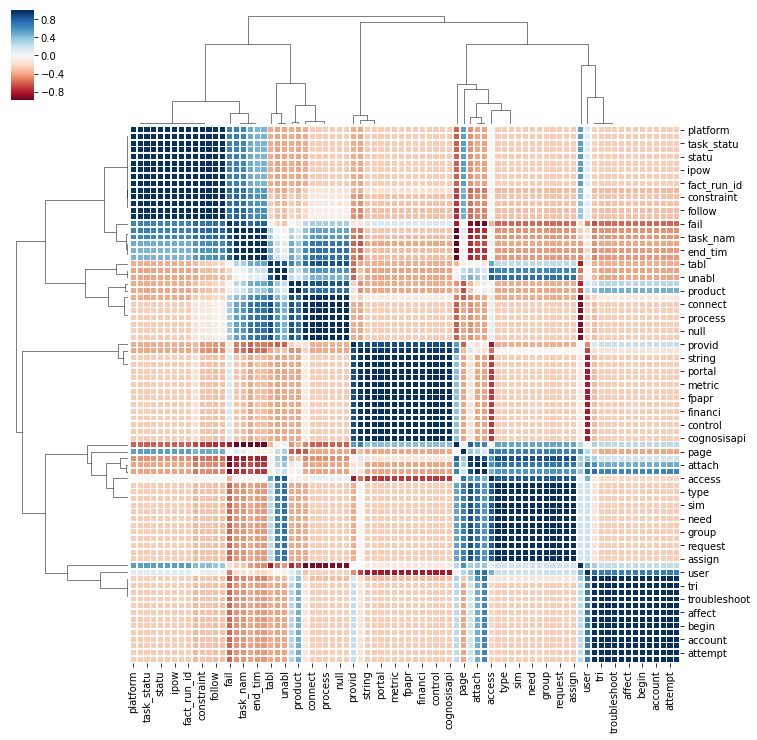

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [78]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [79]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)
    return X_train, X_test, y_train, y_test

In [80]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [81]:
from sklearn.externals import joblib

In [82]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Create Model for Sub_Category
This model will help to preduct the Sub-Category of the ticket.  Category to Sub Category is one to many relationship; so there is no need to preduct Category as using regular code, we can determine the Category

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          3156480   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 5,204,743
Trainable params: 5,204,743
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 109

['model-simple_sub.pkl']

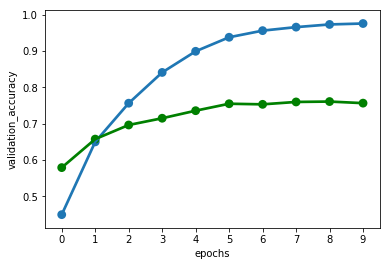

In [83]:

X_train, X_test, y_train, y_test = data_set_split(y_sub)

model_file = 'weights-simple_sub.hdf5'
model = model_training(num_class_sub, model_file)
joblib.dump(model,'model-simple_sub.pkl')


In [84]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.7422279792746114

In [85]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [87]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
encoder.fit(data.Sub_Category.values)
#encoder.fit(data.Resolution_category.values)
#encoder.fit(data.Resolved_by_group.values)
text_labels = encoder.classes_ 


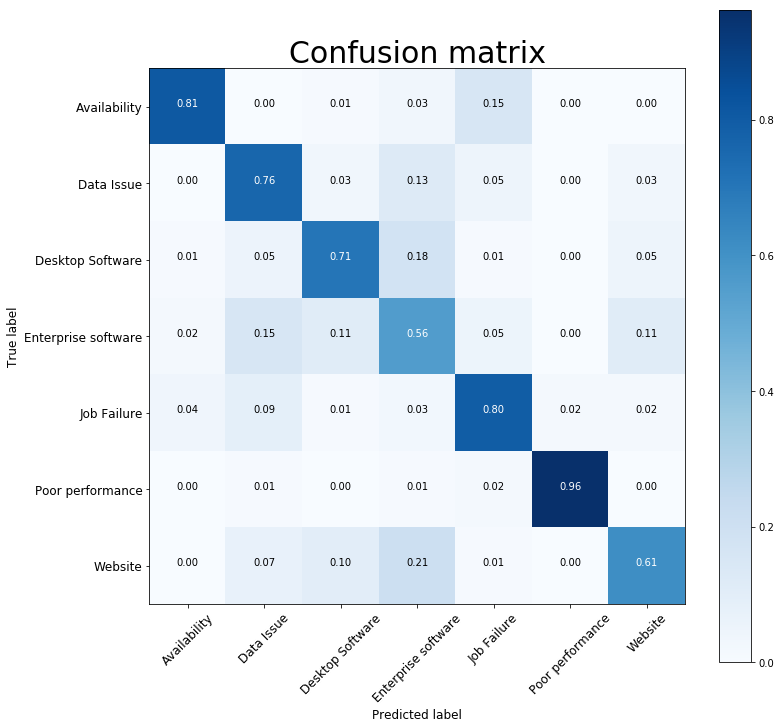

In [88]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [89]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=20, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          3156480   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 3,208,199
Trainable params: 3,208,199
Non-trainable params: 0
_________________________________________________________________
Train on 10986 samples, validate on 3663 samples
Epoch 1/20
10986/10986 [==============================] - 64s 6ms/step - loss: 1.24

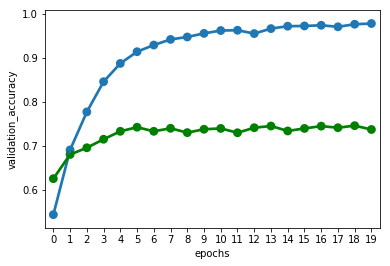

In [90]:
model_lstm = lstm_model_training(num_class_sub,"weights_sub.hdf5")
predicted = model_lstm.predict(X_test)

In [91]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.7344559585492227

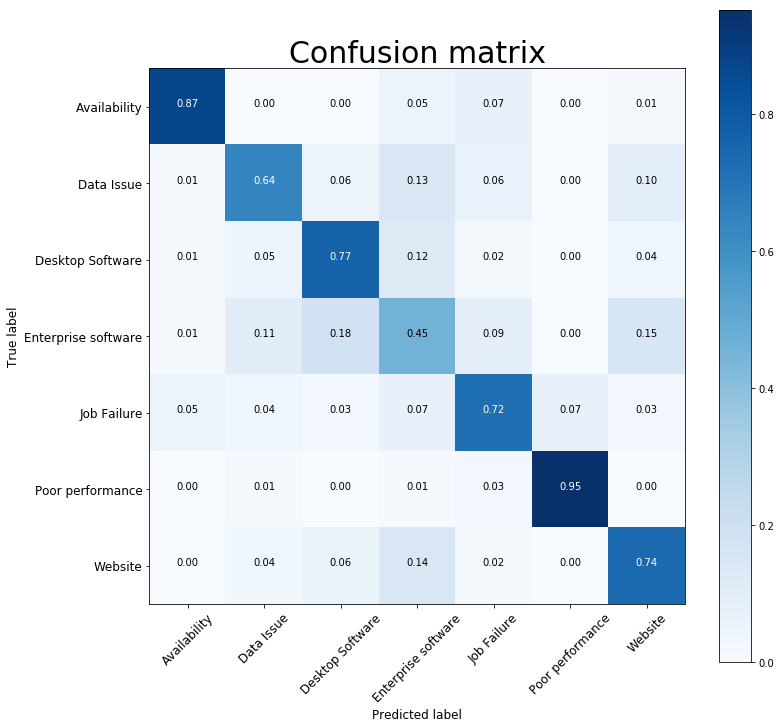

In [92]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        99
           1       0.76      0.64      0.70       126
           2       0.74      0.77      0.75       129
           3       0.42      0.45      0.44        99
           4       0.70      0.72      0.71       103
           5       0.93      0.95      0.94       105
           6       0.69      0.74      0.72       111

   micro avg       0.73      0.73      0.73       772
   macro avg       0.74      0.73      0.74       772
weighted avg       0.74      0.73      0.74       772

